In [5]:
import json
import pandas as pd

# --- Load data ---
with open("/Users/user/XG/WSL 2526/2025-09-28_West Ham United WFC - Chelsea FC Women.json", "r") as f:
    match = json.load(f)

events = match["event"]
df = pd.DataFrame(events)

# --- Possession Segmentation ---
df["team"] = df["contestantId"]

plays = []
current_play = []
current_team = None

for _, row in df.iterrows():
    team = row["team"]
    if current_team is None:
        current_team = team
    if team != current_team:
        if current_play:
            plays.append(current_play)
        current_play = [row.to_dict()]
        current_team = team
    else:
        current_play.append(row.to_dict())
if current_play:
    plays.append(current_play)

# --- Metrics ---
def play_success_rate(play):
    xs = [e.get("x", 0) for e in play if e.get("x") is not None]
    final_third = any(x > 66 for x in xs)
    shot = any(e["typeId"] in [13, 14, 15] for e in play)
    return 1 if (final_third or shot) else 0

def expected_play_value(play):
    for e in play:
        for q in e.get("qualifier", []):
            if q.get("qualifierId") == 213:  # xG-like qualifier
                return float(q.get("value", 0))
    return 0

def is_explosive(play):
    xs = [e.get("x", 0) for e in play if e.get("x") is not None]
    if not xs: return 0
    gain = max(xs) - min(xs)
    return 1 if gain > 30 or expected_play_value(play) > 0.2 else 0

def is_negative(play):
    return 1 if play[-1].get("outcome") == 0 else 0

# --- Collect play metrics ---
play_metrics = []
for play in plays:
    team = play[0]["team"]
    psr = play_success_rate(play)
    xpv = expected_play_value(play)
    exp = is_explosive(play)
    neg = is_negative(play)
    
    players = [e.get("playerId") for e in play if e.get("playerId")]
    player_names = [e.get("playerName") for e in play if e.get("playerName")]
    
    play_metrics.append({
        "team": team,
        "PSR": psr,
        "xPV": xpv,
        "explosive": exp,
        "negative": neg,
        "players": players,
        "player_names": player_names
    })

metrics_df = pd.DataFrame(play_metrics)

# --- Per-player aggregation ---
player_rows = []
for _, row in metrics_df.iterrows():
    for pid, pname in zip(row["players"], row["player_names"]):
        player_rows.append({
            "playerId": pid,
            "playerName": pname,
            "team": row["team"],
            "PSR": row["PSR"],
            "xPV": row["xPV"],
            "explosive": row["explosive"],
            "negative": row["negative"]
        })

players_df = pd.DataFrame(player_rows)

player_summary = players_df.groupby(["playerId", "playerName", "team"]).agg(
    Plays_Involved=("PSR", "count"),
    PSR_Contribution=("PSR", "mean"),
    xPV_Contribution=("xPV", "sum"),
    Explosive_Involved=("explosive", "sum"),
    Negative_Involved=("negative", "sum")
).reset_index()

# Sort by biggest xPV contributors
player_summary = player_summary.sort_values("xPV_Contribution", ascending=False)

# --- Show results ---
print(player_summary.head(20))   # top 20 contributors
# --- Save to Excel ---
team_excel_path = "/Users/user/XG/WSL 2526/WestHam_Chelsea_TeamMetrics.xlsx"
player_excel_path = "/Users/user/XG/WSL 2526/WestHam_Chelsea_PlayerMetrics.xlsx"

# Team-level metrics
metrics_df.to_excel(team_excel_path, index=False)

# Player-level metrics
player_summary.to_excel(player_excel_path, index=False)

print(f"Team metrics saved to: {team_excel_path}")
print(f"Player metrics saved to: {player_excel_path}")



                     playerId          playerName                       team  \
16  anghujtc4achyb9mflowgg9n9           M. Bright   spi3g782q7m4evjxn1sv6cfa   
30   ubxdnr5uuwgcj44lytu3abys          V. Buurman   spi3g782q7m4evjxn1sv6cfa   
3   3c80px00lrpe84s9yurszqcid            N. Björn   spi3g782q7m4evjxn1sv6cfa   
21  dfeohozpw604y5jbu01u1dkkq         A. Thompson   spi3g782q7m4evjxn1sv6cfa   
9   6d8zrjdl4ii8cjpn5vo7emz11          E. Nyström  cz26xwowfjp8ei14n9z2ac135   
14  8h7r4d4z2gjne58xwu3koiok5            K. Walsh   spi3g782q7m4evjxn1sv6cfa   
2   30pcgn07mnn0sk4jp0t7bx9ed         S. Zadorsky  cz26xwowfjp8ei14n9z2ac135   
24  dxojafbkfxjskl0ek4nucrnpx           K. Szemik  cz26xwowfjp8ei14n9z2ac135   
29  f1xb9y38jfjmrhgv22svv9sa2           A. Denton  cz26xwowfjp8ei14n9z2ac135   
1   2m6wew2746q1xsoio3703t8t1  J. Rytting Kaneryd   spi3g782q7m4evjxn1sv6cfa   
17  bnzgfrgoiwlw6boq7e7ngi162            O. Siren  cz26xwowfjp8ei14n9z2ac135   
18  cij18xj0bx2zyx3mi9xwykn9x         E.

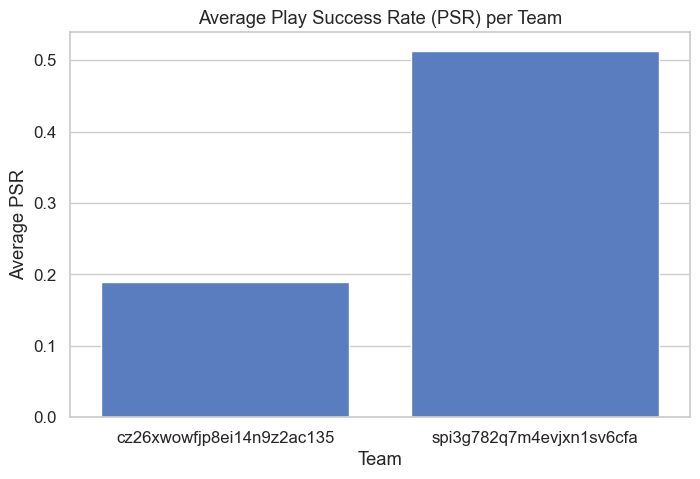

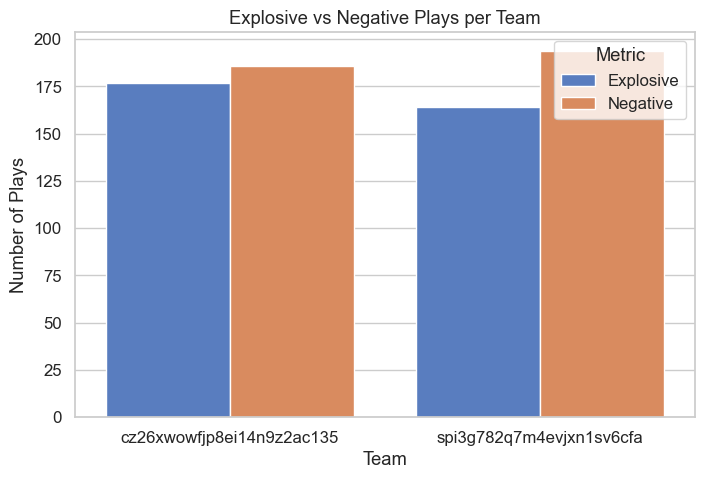

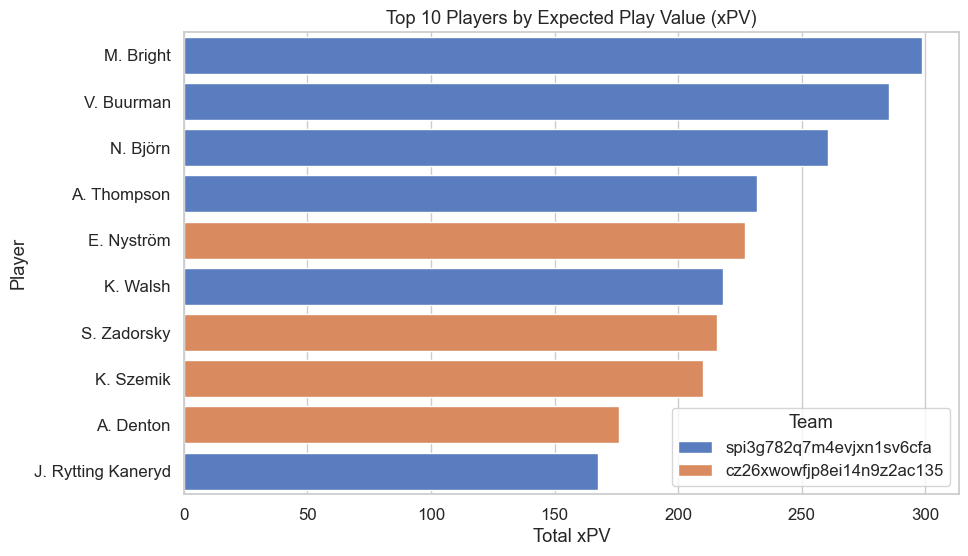

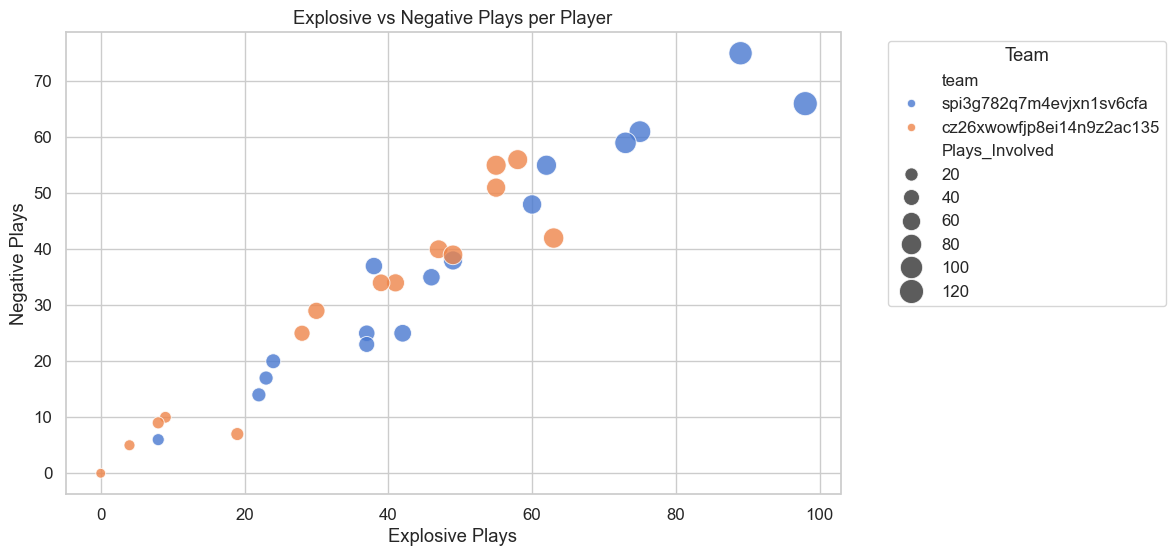

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# --- 1. Team-level metrics ---
team_summary = metrics_df.groupby("team").agg(
    Plays=("PSR", "count"),
    Avg_PSR=("PSR", "mean"),
    Explosive=("explosive", "sum"),
    Negative=("negative", "sum")
).reset_index()

# Plot Avg PSR per team
plt.figure(figsize=(8,5))
sns.barplot(data=team_summary, x="team", y="Avg_PSR")
plt.title("Average Play Success Rate (PSR) per Team")
plt.ylabel("Average PSR")
plt.xlabel("Team")
plt.show()

# Plot Explosive vs Negative plays per team
team_summary_melt = team_summary.melt(id_vars="team", value_vars=["Explosive", "Negative"],
                                      var_name="Metric", value_name="Count")

plt.figure(figsize=(8,5))
sns.barplot(data=team_summary_melt, x="team", y="Count", hue="Metric")
plt.title("Explosive vs Negative Plays per Team")
plt.ylabel("Number of Plays")
plt.xlabel("Team")
plt.show()

# --- 2. Top 10 players by xPV ---
top_players = player_summary.sort_values("xPV_Contribution", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_players, x="xPV_Contribution", y="playerName", hue="team", dodge=False)
plt.title("Top 10 Players by Expected Play Value (xPV)")
plt.xlabel("Total xPV")
plt.ylabel("Player")
plt.legend(title="Team")
plt.show()

# --- 3. Explosive vs Negative Plays per Player ---
plt.figure(figsize=(10,6))
sns.scatterplot(data=player_summary, x="Explosive_Involved", y="Negative_Involved",
                size="Plays_Involved", hue="team", alpha=0.8, sizes=(50, 300))
plt.title("Explosive vs Negative Plays per Player")
plt.xlabel("Explosive Plays")
plt.ylabel("Negative Plays")
plt.legend(title="Team", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/mplsoccer/_pitch_plot.py:167: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  return sns.kdeplot(x=x, y=y, ax=ax, clip=self.kde_clip, **kwargs)


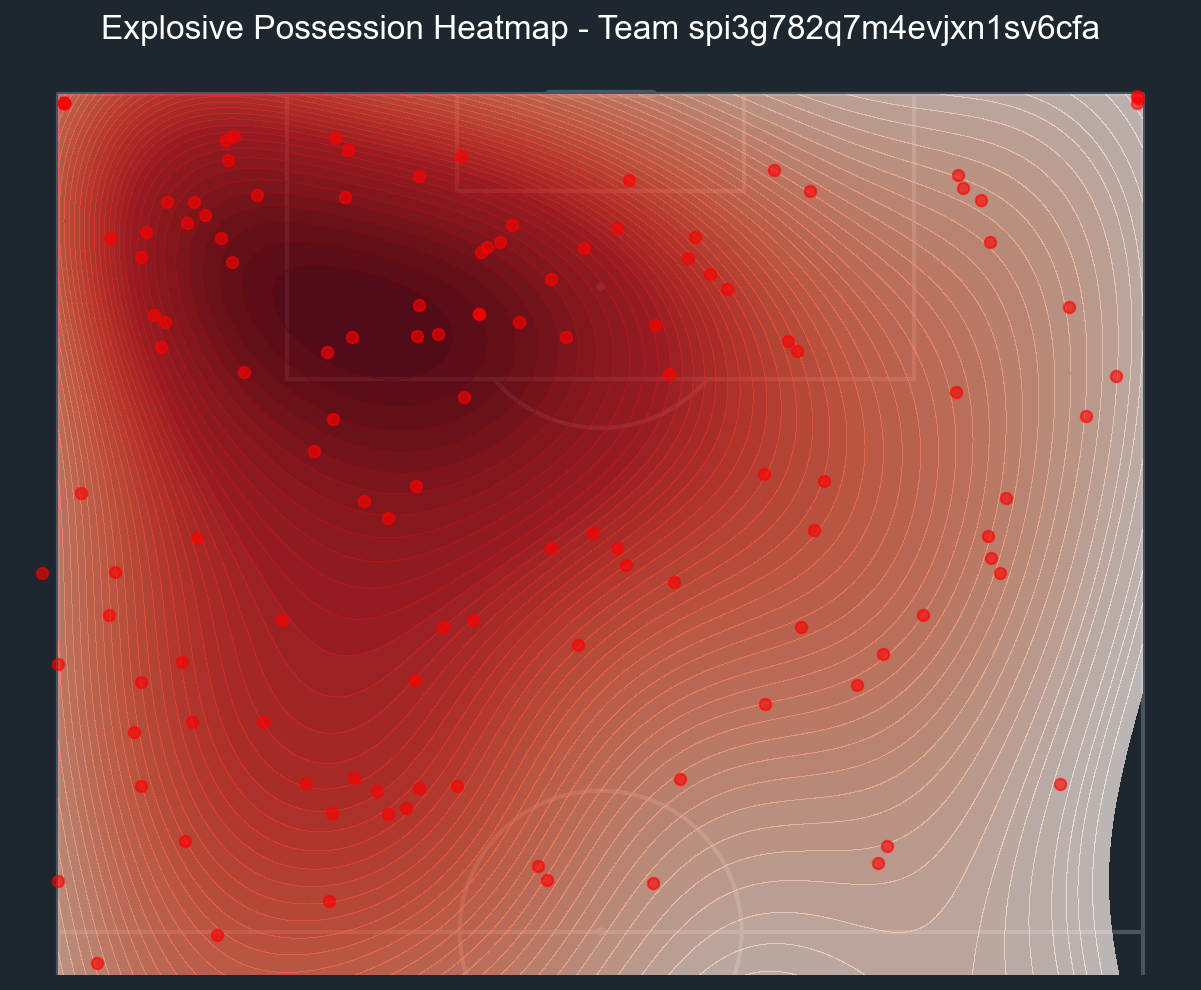

In [11]:
from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt

# --- Choose a team ---
chosen_team = "spi3g782q7m4evjxn1sv6cfa"

# Filter end locations of explosive plays for this team only
explosive_x = []
explosive_y = []

for play in plays:
    if play[0]["team"] == chosen_team and is_explosive(play):
        last_event = play[-1]
        x = last_event.get("x", None)
        y = last_event.get("y", None)
        if x is not None and y is not None:
            explosive_x.append(x)
            explosive_y.append(y)

# --- Dark style ---
plt.style.use("dark_background")

# --- Create figure ---
fig, ax = plt.subplots(figsize=(12, 8), dpi=150)
fig.patch.set_facecolor("#1e272e")
ax.set_facecolor("#1e272e")

# --- Draw vertical half-pitch ---
pitch = VerticalPitch(
    pitch_type='opta',
    half=True,
    pitch_color="#1e272e",
    line_color="#485460",
    axis=False
)
pitch.draw(ax=ax)

# --- Heatmap ---
pitch.kdeplot(
    explosive_x, explosive_y, ax=ax,
    cmap="Reds", shade=True, levels=50, alpha=0.7
)

# --- Overlay dots ---
pitch.scatter(explosive_x, explosive_y, ax=ax, c="red", s=30, alpha=0.6)

plt.title(f"Explosive Possession Heatmap - Team {chosen_team}", fontsize=16, color="white")
plt.show()
